*This Notebook was created by Antoine Palisson*

# Import Packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

/Users/skyemalfoy/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Exploration

In [2]:
from sklearn.datasets import fetch_openml
data = fetch_openml('california_housing', version=1, as_frame=True)
df = pd.concat([data['data'], data['target']], axis=1)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY,342200.0


The California Housing dataset is a dataset about the price of the houses in California.<br> The `median_house_value` target variable is the target.

**<font color='blue'>1.a. What is the task of the dataset ? Is it a classification and a regression ?<br>1.b. What is the type of each feature ? Are they Nominal ? Ordinal ? Cyclical ? Numerical ?**

In [3]:
#1.a It is a regression task.
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
'''
1.b:
Col 1 to 8 are numerical features;
Col 9 is Nominal categorical feature;
'''

'\n1.b:\nCol 1 to 8 are numerical features;\nCol 9 is Ordinal categorical feature;\n'

**<font color='blue'>2. Is there any missing values in the dataset ?**

In [5]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   ocean_proximity     20640 non-null  category
 9   median_house_value  20640 non-null  float64 
dtypes: category(1), float64(9)
memory usage: 1.4 MB


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

#### Yes, there are 207 missing data in the column of total_bedrooms.

**<font color='blue'>3. Is there any duplicates in the dataset ?<br> If so, delete them.**

In [6]:
print(df.shape)
print(df.drop_duplicates().shape)
#So there has no duplicates.

(20640, 10)
(20640, 10)


**<font color='blue'>4. Is there any outliers ? Use a z-score method <br>**

<AxesSubplot:>

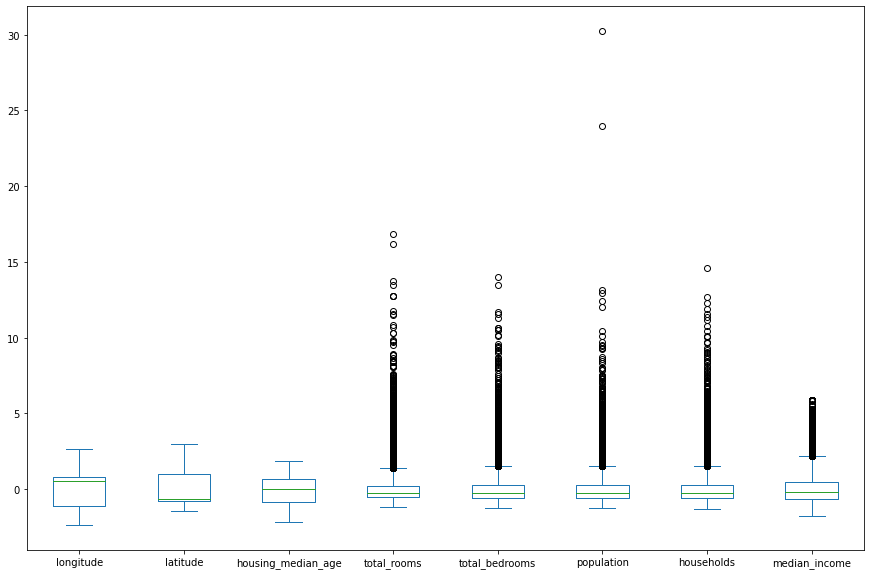

In [7]:
#For numerical features (Column 1 to column 8)
#1. Calculate mean and std values for columns
df_numerical = df.iloc[:, 0:8]
mean_value = df_numerical.mean()
std_value = df_numerical.std()



#2. Calculate the z-score of columns
z_score = (df_numerical - mean_value)/std_value

#3. Plot a boxplot to find out outliers.
z_score.plot.box(figsize=(15,10))

#

#### So we can find out that:
<p>
    <li>Column: Longtitude, Latitude and Housing_median_age do not have outliers.</li>
    <li>Column: Total_rooms, Total_bedrooms, Population, Households and median_income are all have multiple outliers.</li>
</p>

In [8]:
#For categorical features: column 9
df_cat = df['ocean_proximity']
df_cat.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### We can find that value "ISLAND" is an outlier of the categorical feature "Ocean_proximity"

**<font color='blue'>5.a. Analyze the label using graphs and statistics.<br>**

In [9]:
#Show the description of the label
df['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

<b>We can find out that:</b>
  <li>The range of label is around [15000, 500000]</li>
  <li>The std is very large, means that the label varies hugely.</li>
<b>So here we could could draw am histogram to view the distribution of label.</b>

<AxesSubplot:ylabel='Frequency'>

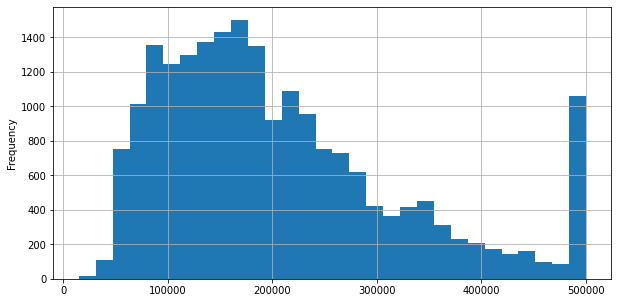

In [10]:
#Histogram
df['median_house_value'].plot.hist(bins=30, figsize=(10,5), grid=True)

<p><b>Some features I found:</b>
    <li>label column's value varies a lot, but they are mainly around 50,000 and 350,000;</li>
    <li>It has a few outliers (lower than lower cutoff);</li>
    <li>Group of values over 500,000 are strange, so we will do a further study on this part.</li>
</p>

500001.0    965
500000.0     27
483300.0      6
485000.0      3
495500.0      3
           ... 
498600.0      1
490300.0      1
492200.0      1
488500.0      1
492000.0      1
Name: median_house_value, Length: 64, dtype: int64

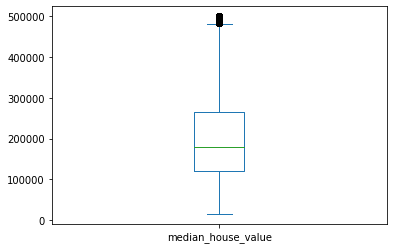

In [11]:
#Boxplot
df['median_house_value'].plot.box()
#Calculate the outliers
Q1 = df['median_house_value'].quantile(0.25)
Q3 = df['median_house_value'].quantile(0.75)
IQR = Q3 - Q1
#Upper outliers
df[df['median_house_value'] > (Q3 + 1.5 * IQR)]['median_house_value'].value_counts()


<p>We selected out the big outliers (greater than higher cutoff), it shows out multiple values of 500,001, here we assume that the dataset chooses to musk values over 500,001 and to make them 500,001.</p>

**<font color='blue'>5.b. Analyze the features one by one using graphs, statistics ...<br>**

<b>Before doing analytics, we should decide which columns need analysis while the others do need.</b>
<p>We decide to do analytics on column 3 to column 9 <b>(apart from longtide and latitude)</b> because these two are geographical features, they are not worthing analysing.</p>

### 1. Numerical features: housing_median_age, total_rooms, total_bedrooms, population, households, median_income

In this case, we decide to analyse all numerical features together.

In [12]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<b>According the description of values in this column, we decide to set 50 bins to the histogram.</b>

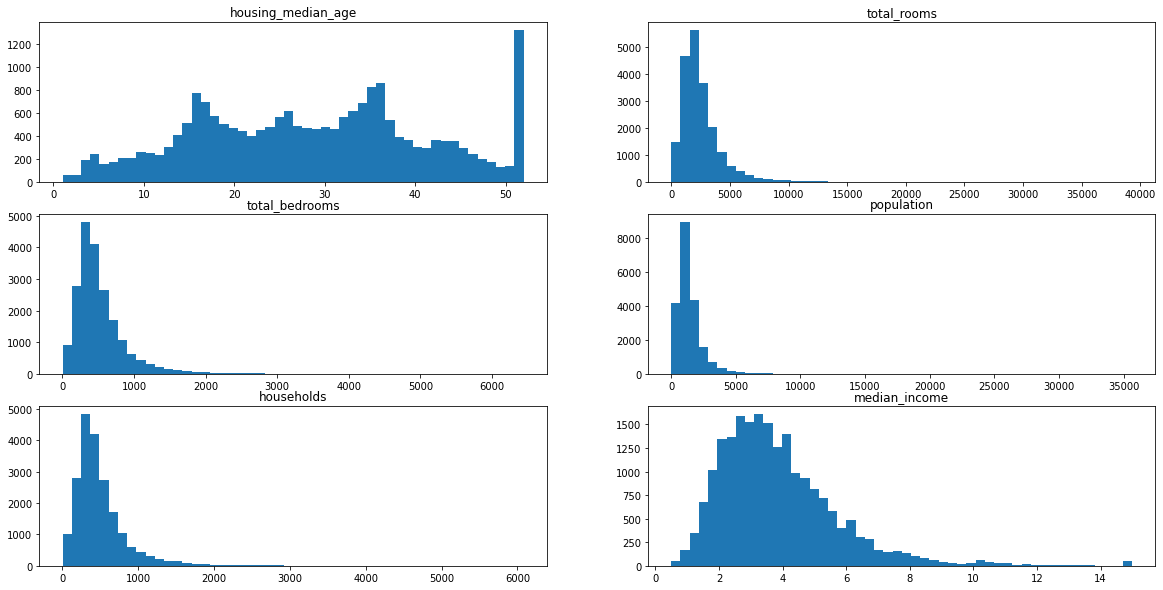

In [13]:
fig, axs = plt.subplots(3,2, figsize=(20,10))

for col, ax in zip(df_numerical.iloc[:, 2:].columns, np.ravel(axs)):
    ax.hist(df_numerical[col], bins=50)
    ax.set_title(col)

plt.show()

<b>We can find out from the graphs that:</b>
<li>Housing median ages have the basic trend of <b>normal distribution.</b> (apart from the biggest values)</li>
<li>The other columns seems like <b>normal distribution</b> too but they are not in the center of the graph.</li>

<b> So here, in order to have a better analysis on the crooked five features, we calculate the log2 values for them</b>

In [14]:
crooked_features = ['total_rooms', "total_bedrooms", 'population', 'households', 'median_income']
df_crooked = pd.DataFrame()
for c in crooked_features:
    df_crooked['cf_' + c] = np.log2(df_numerical[c])

df_crooked

,cf_total_rooms,cf_total_bedrooms,cf_population,cf_households,cf_median_income
0,9.781360,7.011227,8.330917,6.977280,3.057485
1,12.793400,10.111136,11.229420,10.152285,3.053355
2,10.518653,7.569856,8.954196,7.467606,2.859453
3,10.315150,7.876517,9.124121,7.774787,2.496488
4,10.667999,8.129283,9.142107,8.016808,1.943434
...,...,...,...,...,...
20635,10.701306,8.546894,9.722808,8.366322,0.641823
20636,9.445015,7.228819,8.475733,6.832890,1.354339
20637,11.138272,8.921841,9.975848,8.758223,0.765535
20638,10.861087,8.675957,9.533330,8.447083,0.900876


<b>We draw the histgrams again, they are showed like in the following graphs.</b> 
</br>
It helps us to clearify the outliers of values.

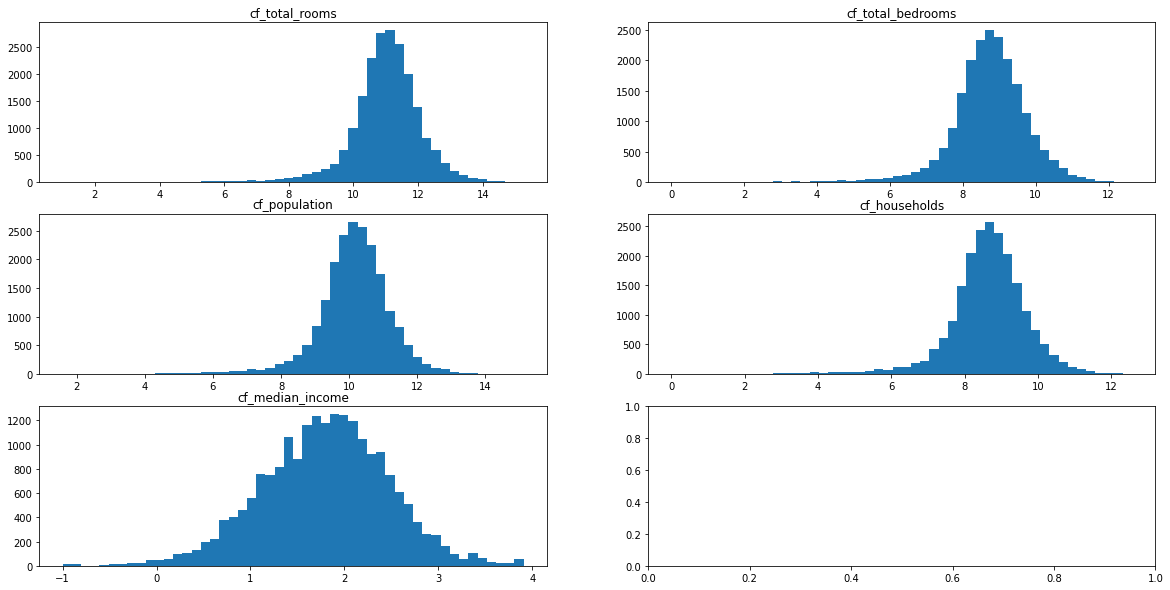

In [15]:
fig, axs = plt.subplots(3,2, figsize=(20,10))

for col, ax in zip(df_crooked.columns, np.ravel(axs)):
    ax.hist(df_crooked[col], bins=50)
    ax.set_title(col)

plt.show()

### 2. Categorical feature: ocean proximity.

<b>2.1 Count values</b>

In [16]:
count_ocean_proximity = df['ocean_proximity'].value_counts()
count_ocean_proximity

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Is this case, we draw an horizental bar graph to see the amount of each value in this feature.

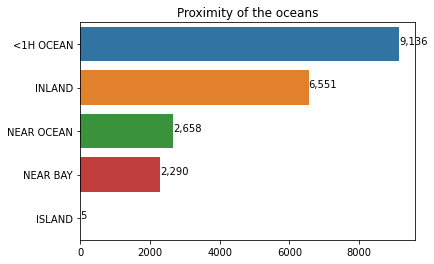

In [17]:
plt.title('Proximity of the oceans')
bar_op = sns.barplot(x=count_ocean_proximity.values, y=count_ocean_proximity.keys(), orient='h', order=count_ocean_proximity.keys())
#Add numbers to bars
for i in range(len(count_ocean_proximity.values)):
    bar_op.text(count_ocean_proximity.values[i], i, (lambda x: format(x, ','))(count_ocean_proximity.values[i]), color='black',ha='left')

**<font color='blue'>6.a. Analyze the relationships between the features using graphs, correlation ...<br>**

<b>For analysing correlations between features, we plan to use heatmap.</b> <br/>
Here I also draw the lower triangle are of the heatmap

In [18]:
#Get correlation data
corr = df.iloc[:, :-1].corr()
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000


/var/folders/q7/h0qy2kmn1617pwg3_l5zhc7c0000gn/T/ipykernel_2839/1993785414.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


Text(0.5, 1.0, 'Heatmap of all the features')

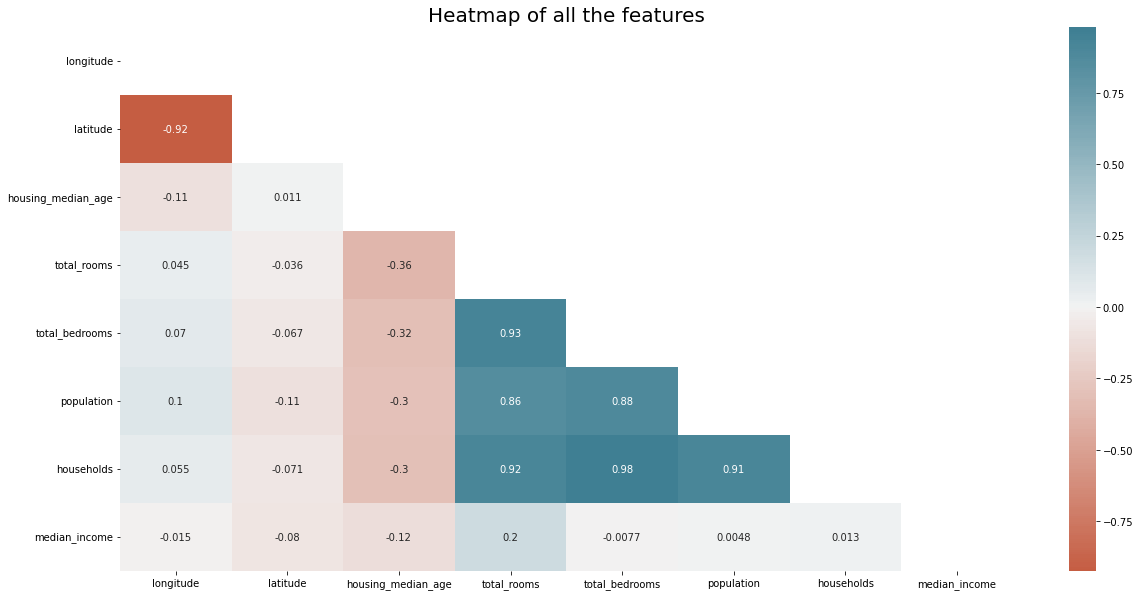

In [19]:
plt.subplots(figsize=(20, 10))

#Heatmap
#Give mask to the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Draw figures
sns.heatmap(corr,
           cmap=sns.diverging_palette(20, 220, n=200),
           mask=mask,
            annot=True,
            center=0
           )

plt.title("Heatmap of all the features", fontsize=20)

<b>We can discover from the graph that:</b>
<li>The two geographical features have a big but negative correlation.</li>
<li>The number of rooms, bedrooms, population and households have big correlations between each other.</li>
<b>On the contrary:</b>
<li>Median_income has a weak correlation with the rest of features.</li>

**<font color='blue'>6.b. Analyze the feature-label relationships using graphs, correlation ...<br>**


### 1. Numerical features - label analysis

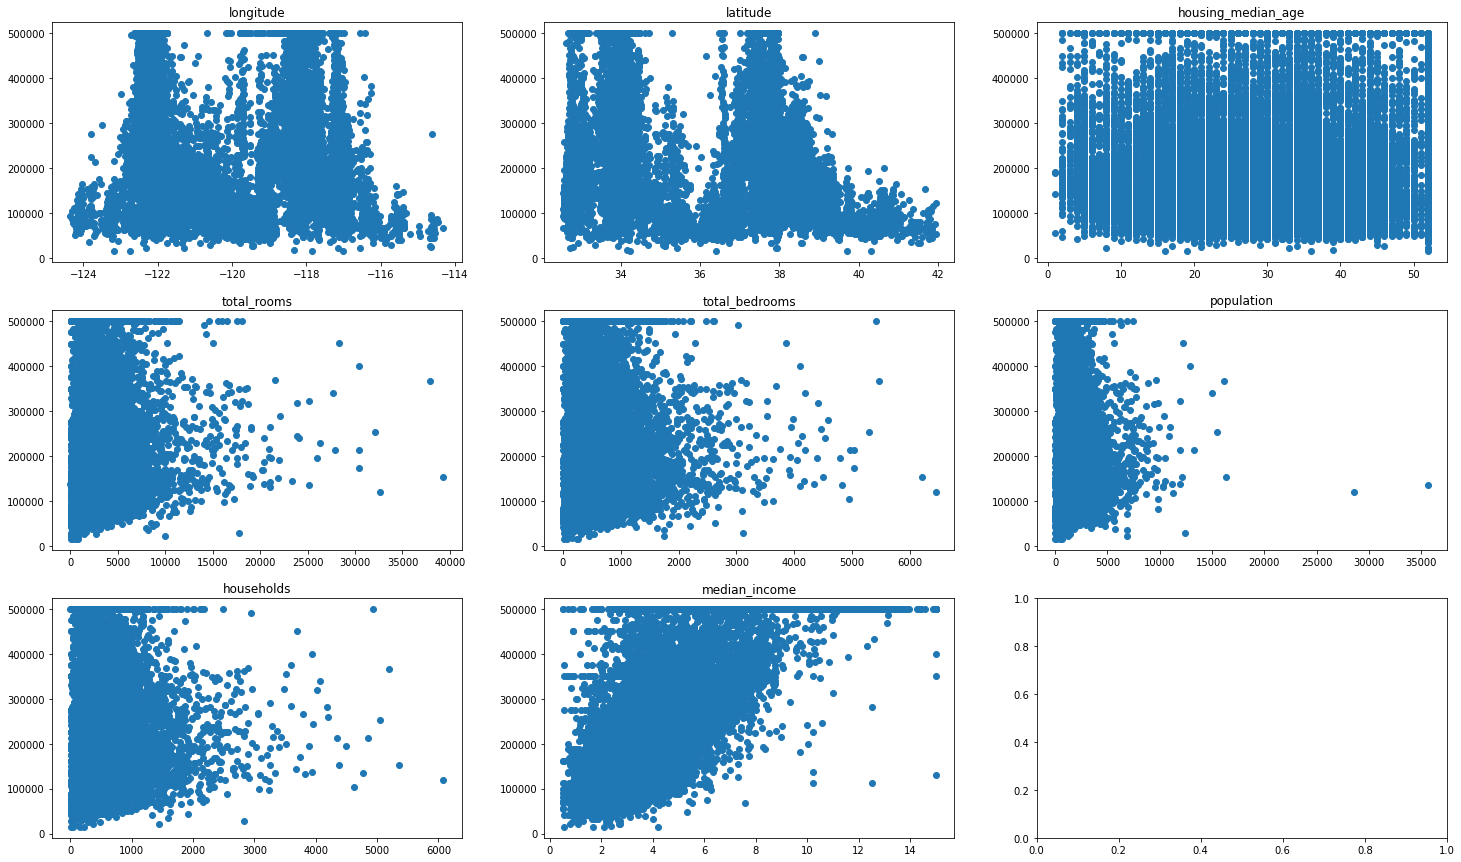

In [20]:
fig, axs = plt.subplots(3,3, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
    ax.scatter(df[col], df['median_house_value'])
    ax.set_title(col)

plt.show()


### 3. Feature - feature analysis

As it has over 20,000 data, so if we draw bubble graph (size of the bubble depends on the value of median_house_value. Bubbles will fully cover the graphs. Like the following charts. So we only make graphs of scatter plot.

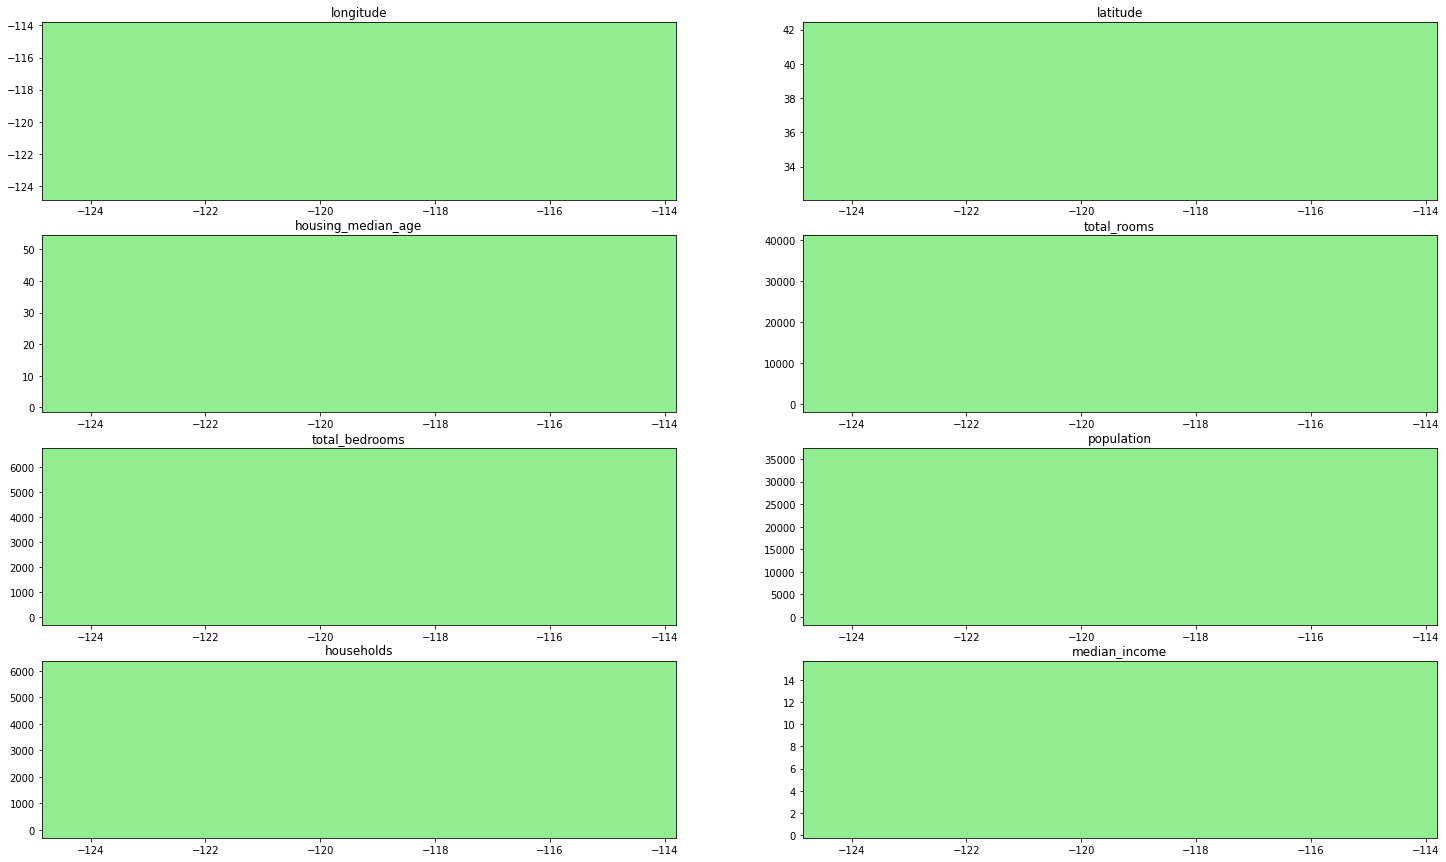

In [21]:
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
    ax.scatter(df['longitude'], df[col], marker="o", c='lightgreen', s=df['median_house_value'])
    ax.set_title(col)

plt.show()

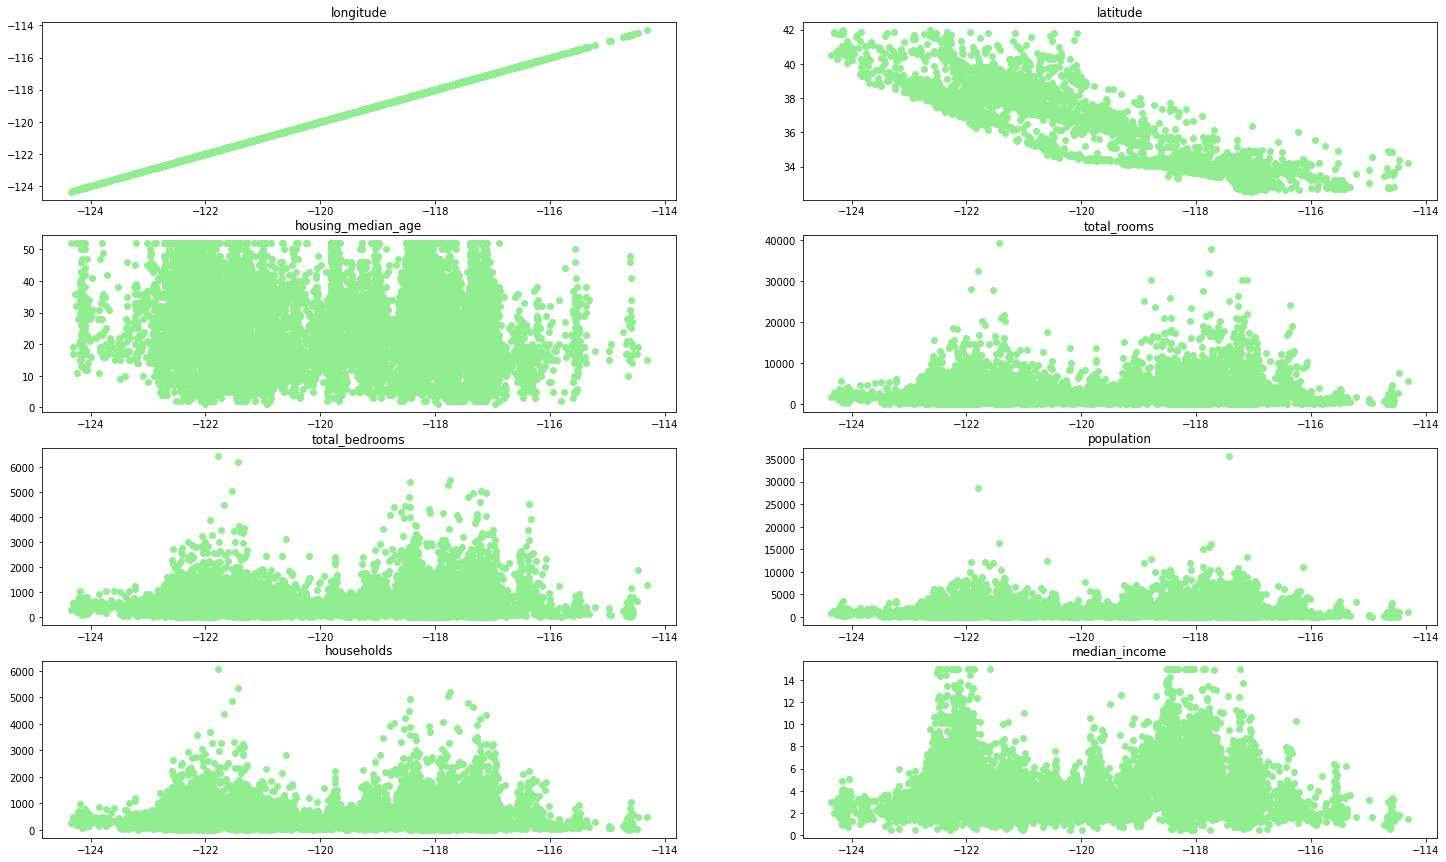

In [22]:
# Logitude and other numerical features.
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
        ax.scatter(df['longitude'], df[col], marker="o", c='lightgreen')
        ax.set_title(col)

plt.show()

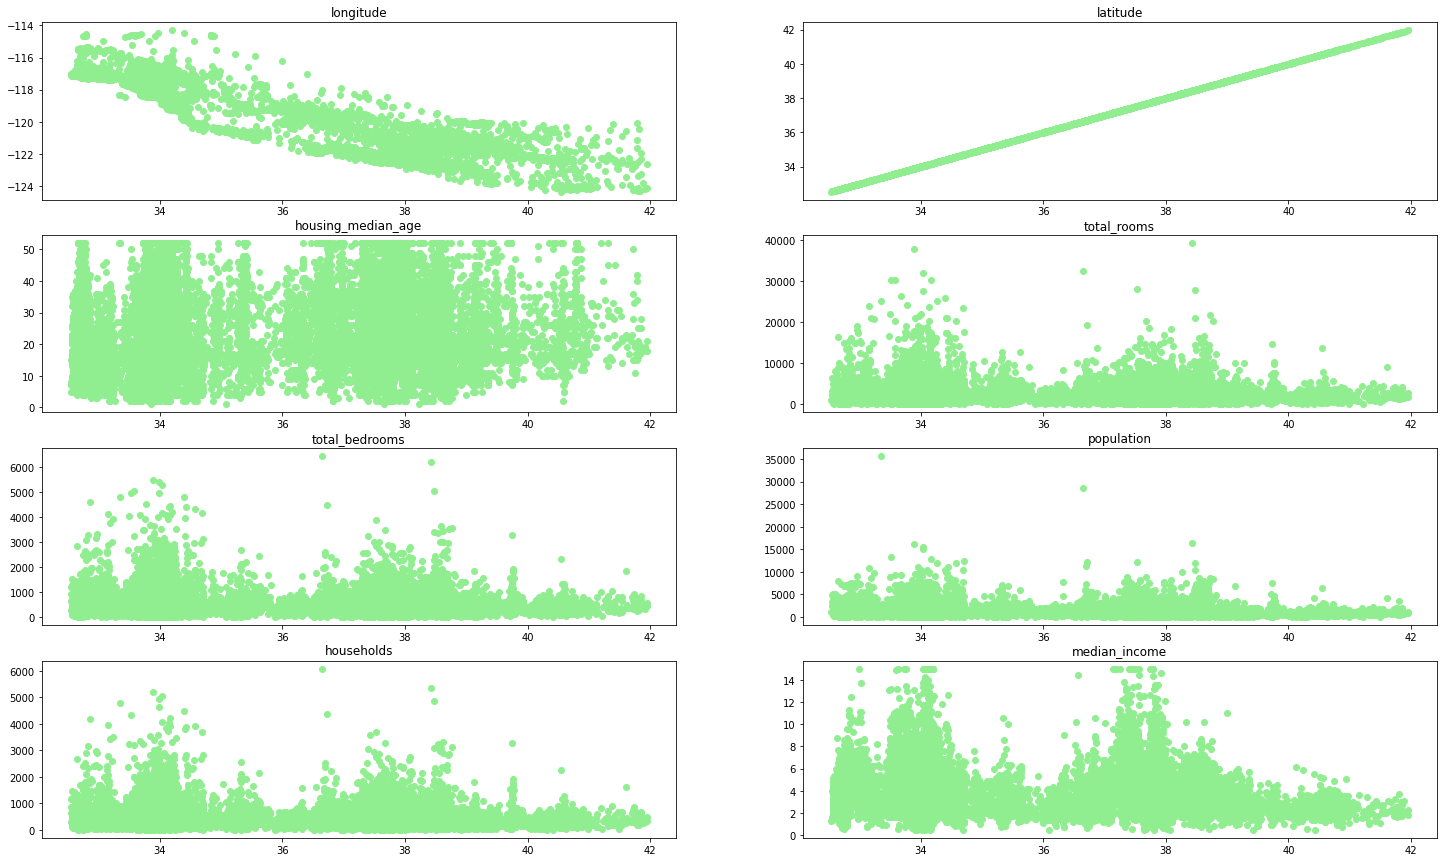

In [23]:
# Latitude and other numerical features.
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
        ax.scatter(df['latitude'], df[col], marker="o", c='lightgreen')
        ax.set_title(col)

plt.show()

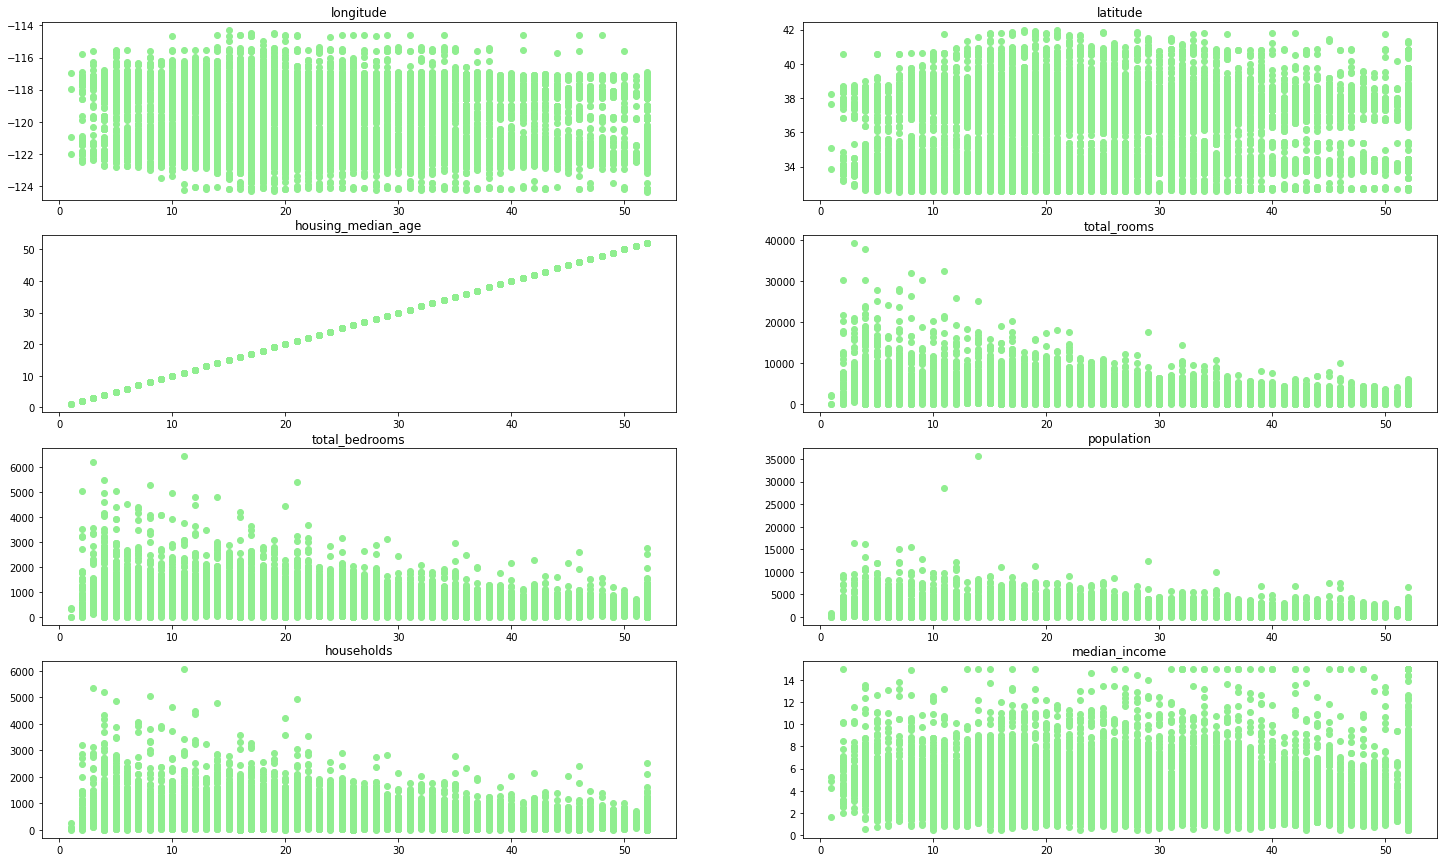

In [24]:
# Housing median age and other numerical features.
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
        ax.scatter(df['housing_median_age'], df[col], marker="o", c='lightgreen')
        ax.set_title(col)

plt.show()

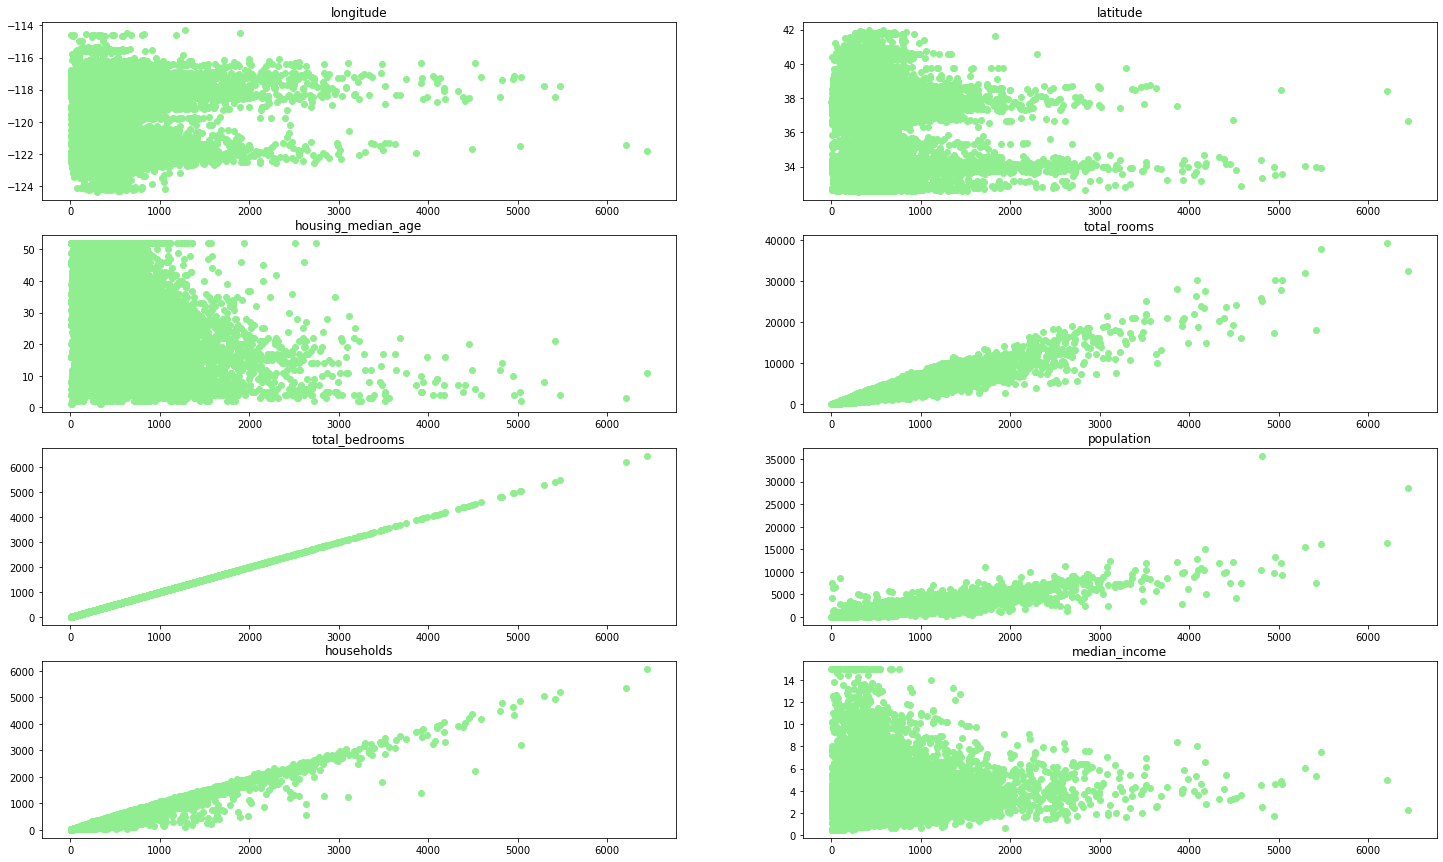

In [25]:
# Total bedrooms and other numerical features.
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
        ax.scatter(df['total_bedrooms'], df[col], marker="o", c='lightgreen')
        ax.set_title(col)

plt.show()

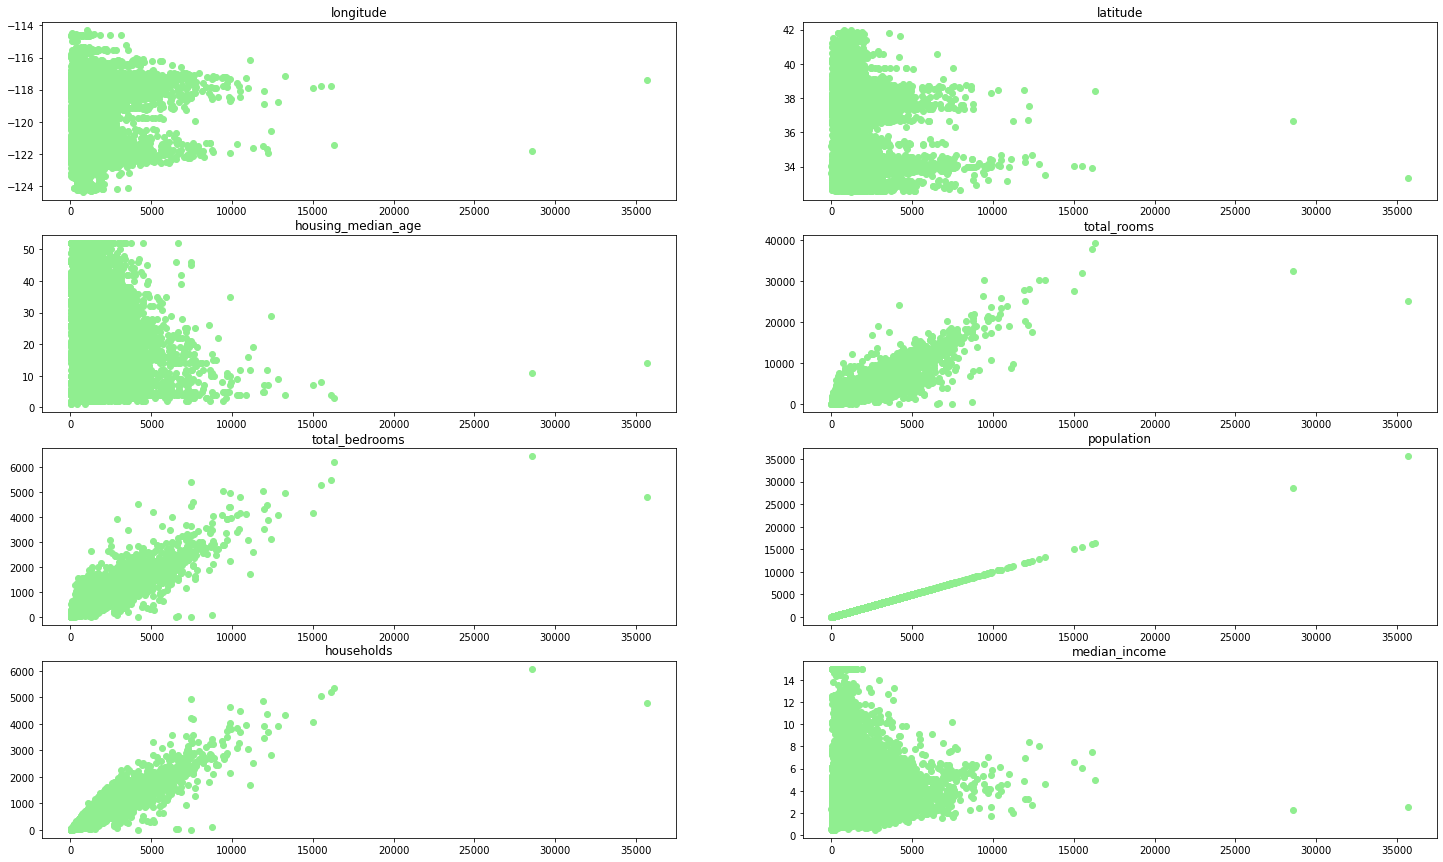

In [26]:
# Population and other numerical features.
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
        ax.scatter(df['population'], df[col], marker="o", c='lightgreen')
        ax.set_title(col)

plt.show()

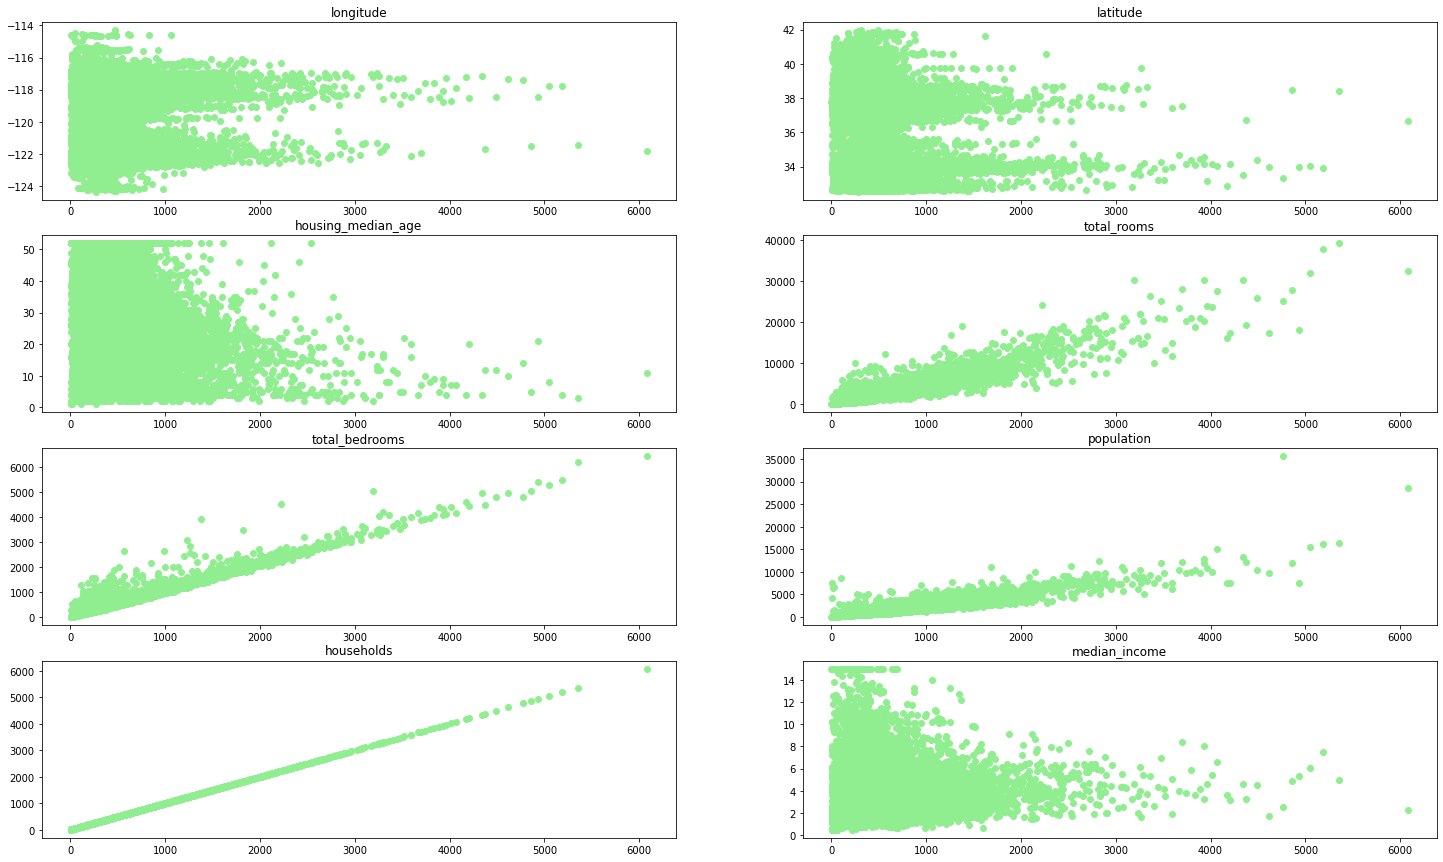

In [27]:
# Households bedrooms and other numerical features.
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
        ax.scatter(df['households'], df[col], marker="o", c='lightgreen')
        ax.set_title(col)

plt.show()

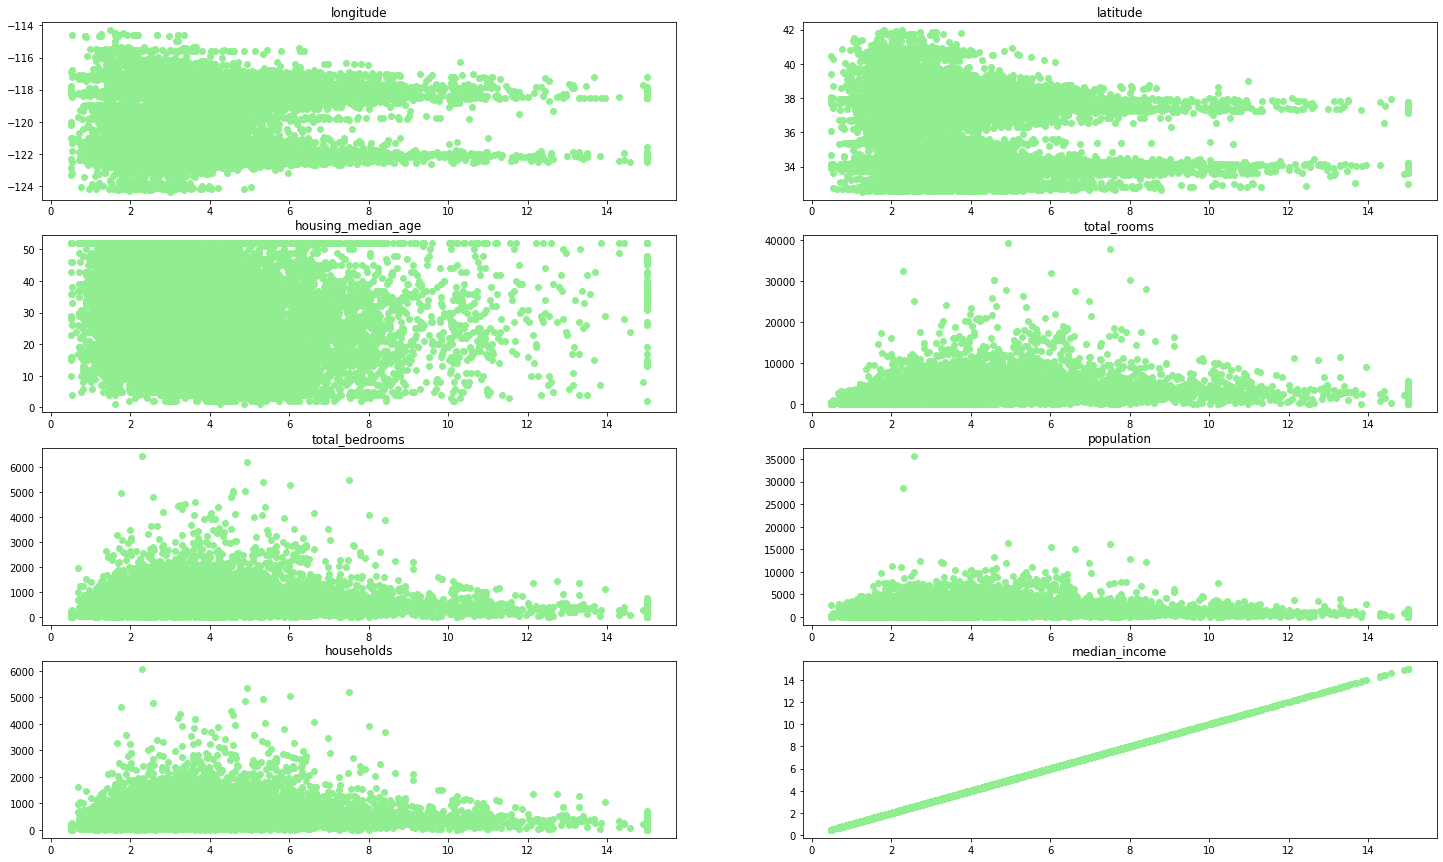

In [28]:
# Median income and other numerical features.
fig, axs = plt.subplots(4,2, figsize=(25,15))

for col, ax in zip(df.columns[:-2], np.ravel(axs)):
        ax.scatter(df['median_income'], df[col], marker="o", c='lightgreen')
        ax.set_title(col)

plt.show()

# Data Preprocessing

**<font color='blue'>1.a. Split the dataset into the features (X) and the label (y).**

In [30]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

**<font color='blue'>1.b. Split the dataset into a training, a validation and testing set. Should you stratify ?**

<b>In this case, we prefer to split the dataset following the rules:</b>
<li>70% for train set;</li>
<li>10% for validation set;</li>
<li>20% for test set.</li>
<b>Because this is a regression problem, so we will not stratify sub datasets in this case.</b>

In [31]:
#Without stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
print(X_train.shape)
print(X_test.shape)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=1/3)
print(X_val.shape)
print(X_test.shape)

(14447, 9)
(6193, 9)
(2064, 9)
(4129, 9)


**<font color='blue'>2. Handle the missing values.**

In [32]:
#Judge if there has missing values
X_train.isna().sum()

#Study this feature
X_train['total_bedrooms'].describe()

count    14289.000000
mean       535.701659
std        417.551093
min          2.000000
25%        296.000000
50%        435.000000
75%        643.000000
max       6210.000000
Name: total_bedrooms, dtype: float64

Here we use SimpleImputer to impute the mussing values with median value.

In [33]:
#Utilize SimpleImputer to fill out all the missing values with median value.
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

#Creating new column of missing value to training set
imp_median.fit(X_train[['total_bedrooms']])
X_train_replace = imp_median.transform(X_train[['total_bedrooms']])
#Replace data
X_train.loc[:, 'total_bedrooms'] = X_train_replace

#Creating new column of missing value to validation and test set
X_val_replace = imp_median.transform(X_val[['total_bedrooms']])
X_test_replace = imp_median.transform(X_test[['total_bedrooms']])
#Replace data
X_val.loc[:, 'total_bedrooms'] = X_val_replace
X_test.loc[:, 'total_bedrooms'] = X_test_replace

In [34]:
X_train['total_bedrooms'].isnull().sum()

0

**<font color='blue'>3. Handle the outliers**



### 1. Numerical Features
<p>Here we plan to first calculate the amount of values over the higher cutoff for every numerical numbers and the decide what could we do to the outliers.<br/><br/>
What is more, longtide, latitude and housing median age have not got any outliers here, so we ignore these columns in this part. 
    </p>

In [35]:
#Boxplot
# df['median_house_value'].plot.box()
#Calculate the outliers
Q1 = X_train.iloc[:, 3:8].quantile(0.25)
Q3 = X_train.iloc[:, 3:8].quantile(0.75)
IQR = Q3 - Q1
high_cut = Q3 + 1.5 * IQR

#Upper outliers
X_train[X_train.iloc[:, 3:8] > high_cut].iloc[:, 3:8].notnull().sum()


total_rooms       916
total_bedrooms    912
population        849
households        859
median_income     463
dtype: int64

<p>Here we can see that these columns all have a big amount of outliers, so we can not abandon all columns directly.<br/><br/>
Instead, we try to replace all outliers with the higher cutoff value. (Because we do not have values lower than lower cutoff)
</p>

**<font color='blue'>4. Preprocess the numerical data using the correct method.**

In [36]:
# Replace outliers
print(X_train)
X_train.iloc[:, 3:8] = X_train.iloc[:, 3:8].mask(
    cond=X_train.iloc[:, 3:8] > high_cut,
    other=Q3,
    axis=1
)

print(X_train)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11871    -117.35     34.00                38.0       1214.0           254.0   
2602     -123.52     41.01                17.0       1564.0           345.0   
9020     -118.80     34.15                 9.0       1143.0           179.0   
19037    -121.99     38.36                35.0       2728.0           451.0   
9168     -118.56     34.42                 2.0        966.0           270.0   
...          ...       ...                 ...          ...             ...   
9517     -123.20     39.15                27.0        990.0           238.0   
6107     -117.90     34.11                37.0       1286.0           255.0   
5152     -118.26     33.95                38.0       1387.0           346.0   
13449    -117.40     34.08                21.0       3622.0           667.0   
4219     -118.28     34.11                45.0       1607.0           331.0   

       population  households  median_income ocean_

### 2. Categorical features

**<font color='blue'>5. Preprocess the categorical data using the correct method.**
<p>According to the analysis before, we can find that it has only one categorical feature and it has only one value "ISLAND" can be seen as the 'outlier'. <br/><br/>
So we choose to merge this outlier with another value in this feature. (Here we choose to merge with near ocean). Thus, now, NEAR OCEAN = ISLAND + NEAR OCEAN.
</p>

In [37]:
print('''Values for training set:\n{0}, for validation set:\n{1}, for testing set:\n{2}'''.format(
    X_train['ocean_proximity'].value_counts(), 
    X_val['ocean_proximity'].value_counts(),
    X_test['ocean_proximity'].value_counts()))

Values for training set:
<1H OCEAN     6405
INLAND        4603
NEAR OCEAN    1847
NEAR BAY      1590
ISLAND           2
Name: ocean_proximity, dtype: int64, for validation set:
<1H OCEAN     925
INLAND        636
NEAR OCEAN    267
NEAR BAY      236
ISLAND          0
Name: ocean_proximity, dtype: int64, for testing set:
<1H OCEAN     1806
INLAND        1312
NEAR OCEAN     544
NEAR BAY       464
ISLAND           3
Name: ocean_proximity, dtype: int64


In [38]:
#Merge values for training set
index_island = X_train[X_train['ocean_proximity'] == "ISLAND"]['ocean_proximity'].index
X_train.loc[index_island, 'ocean_proximity'] = 'NEAR OCEAN'

#Merge values for validation set
index_island = X_val[X_val['ocean_proximity'] == "ISLAND"]['ocean_proximity'].index
X_val.loc[index_island, 'ocean_proximity'] = 'NEAR OCEAN'

#Merge values for testing set
index_island = X_test[X_test['ocean_proximity'] == "ISLAND"]['ocean_proximity'].index
X_test.loc[index_island, 'ocean_proximity'] = 'NEAR OCEAN'

In [39]:
print('''Values for training set:\n{0}, for validation set:\n{1}, for testing set:\n{2}'''.format(
    X_train['ocean_proximity'].value_counts(), 
    X_val['ocean_proximity'].value_counts(),
    X_test['ocean_proximity'].value_counts()))

Values for training set:
<1H OCEAN     6405
INLAND        4603
NEAR OCEAN    1849
NEAR BAY      1590
ISLAND           0
Name: ocean_proximity, dtype: int64, for validation set:
<1H OCEAN     925
INLAND        636
NEAR OCEAN    267
NEAR BAY      236
ISLAND          0
Name: ocean_proximity, dtype: int64, for testing set:
<1H OCEAN     1806
INLAND        1312
NEAR OCEAN     547
NEAR BAY       464
ISLAND           0
Name: ocean_proximity, dtype: int64


<b>Here we will do mapping to the categorical feature and change them into numerical values.<br/><br/>
    Because it will show the error of ”could not convert string to float: '<1H OCEAN'“

</b>

In [40]:
# categorical values mapping
X_train['ocean_proximity'] = X_train['ocean_proximity'].map({
    '<1H OCEAN': 0,
    'INLAND': 1,
    'NEAR OCEAN': 2,
    'NEAR BAY': 3
})
#Then we can find that the values has been mapped.
print(X_train['ocean_proximity'])

11871    1.0
2602     1.0
9020     2.0
19037    1.0
9168     0.0
        ... 
9517     0.0
6107     0.0
5152     0.0
13449    1.0
4219     0.0
Name: ocean_proximity, Length: 14447, dtype: float64


In [41]:
#Apply the same mapping method on the validation dataset and test dataset.
#Validation set
# categorical values mapping
X_val['ocean_proximity'] = X_val['ocean_proximity'].map({
    '<1H OCEAN': 0,
    'INLAND': 1,
    'NEAR OCEAN': 2,
    'NEAR BAY': 3
})
#Then we can find that the values has been mapped.
print(X_val['ocean_proximity'])

4230     0.0
15013    2.0
7880     0.0
10335    0.0
17900    0.0
        ... 
12143    1.0
110      3.0
3460     0.0
18927    3.0
17824    0.0
Name: ocean_proximity, Length: 2064, dtype: float64


In [42]:
#Test set
# categorical values mapping
X_test['ocean_proximity'] = X_test['ocean_proximity'].map({
    '<1H OCEAN': 0,
    'INLAND': 1,
    'NEAR OCEAN': 2,
    'NEAR BAY': 3
})
#Then we can find that the values has been mapped.
print(X_test['ocean_proximity'])

13863    1.0
8164     0.0
20439    0.0
16792    2.0
13270    1.0
        ... 
1357     1.0
18093    0.0
8901     0.0
14480    2.0
16743    2.0
Name: ocean_proximity, Length: 4129, dtype: float64


# Model Training

The multiple linear regression is a very simple model for regression that tries to fit a linear function to the data by finding the optimal values for the coefficients that minimize the mean squared error between the predicted values and the actual values.

`LinearRegression` can be found in sklearn [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).

It has two important parameters:


*   **`fit_intercept`**: whether to fit the intercept term in the linear model (default=True).
*   **`normalize`**: whether to normalize the input variables (default=False).

To train the model:


1.   First, import the `LinearRegression` module from `sklearn.linear_model`.
2.   Then, create an instance of the `LinearRegression` class and call the `fit(X, y)` method with the input data X and label values y to train the model.


**<font color='blue'>1.a. Using the `LinearRegression` model from sklearn, train the model on the training set.**

In [43]:
L_reg = LinearRegression().fit(X_train, y_train)

The `LinearRegresion` class in sklearn has many attributes.<br>Here are some of the most important ones:

*  **`coef_`**: the coefficients of the linear regression model.
*  **`intercept_`**: the intercept term of the linear regression model.
*  **`rank_`**: the rank of the input matrix.
*  **`singular_`**: the singular values of the input matrix.

**<font color='blue'>1.b. Use the `.coef_` and and the `.intercept_` attributes to get the coefficients and the bias of the multiple linear regression.<br> Which feature seems to be the most important ?**

In [44]:
print(L_reg.coef_)
print(L_reg.intercept_)
print("Prediction Y = {0}*X0 + {1}*X1 + {2}*X2 + {3}*X3 + {4}*X4 + {5}*X5 + {6}*X6 + {7}*X7 + {8}*X8 + {9}".format(
    L_reg.coef_[0],
   L_reg.coef_[1],
    L_reg.coef_[2],
    L_reg.coef_[3],
    L_reg.coef_[4],
    L_reg.coef_[5],
    L_reg.coef_[6],
    L_reg.coef_[7],
    L_reg.coef_[8],
    L_reg.intercept_
))

[-4.84715050e+04 -4.86679466e+04  1.21963292e+03  1.27915252e+01
  9.30054318e+01 -5.72666895e+01  2.74721165e+01  4.04079637e+04
 -2.59534478e+03]
-4049933.2453554105
Prediction Y = -48471.50499086257*X0 + -48667.946628674246*X1 + 1219.632923343923*X2 + 12.791525199841999*X3 + 93.0054317780232*X4 + -57.266689467345714*X5 + 27.472116512089997*X6 + 40407.963677161075*X7 + -2595.3447761793445*X8 + -4049933.2453554105


From the formula showed upwards, we can find out that <b>"median_income ocean"</b> is the most important feature as it has the biggest coefficient.

The `LinearRegresion` class in sklearn has many methods.<br>Here are some of the most important ones:

* **`fit(X, y)`**: fits the linear regression model to the input data X and label values y.
* **`predict(X)`**: predicts the label values for the input data X.
* **`score(X, y)`**: returns the $R^2$ coefficient of determination of the linear regression model, which measures the proportion of the variance in the label variable that is explained by the model.

**<font color='blue'>1.c. Get the $R^2$ of the multiple linear regression using the `.score()` function on the validation set.**

In [45]:
L_reg.score(X_val, y_val)

0.589899416979897

It shows that we get about <b>60%</b> of the score for $R^2$, it means that this model does not fit very well on the validation set and it needs improve.

**<font color='blue'>1.d. Predict the label values using the `.predict()` method.**

In [1]:
pre_val = L_reg.predict(X_val)
print(pre_val.head(10))

NameError: name 'L_reg' is not defined

The $R^2$ is generally not a good metric and should not be used.

Fortunately, sklearn has many metric functions. 

**<font color='blue'>1.e. Calculate the mean squared error and the root mean squared error using the `mean_squared_error` function from sklearn using the predictions and the true values.**

In [47]:
mean_squared_error(y_val, pre_val)

5732322900.337112

**The `cross_val_score` function in scikit-learn is a convenient way to perform cross-validation and obtain a score for each fold.** The function takes as input a model, the input data X, the label values y, and the number of folds. It then splits the data into a number of folds, fits the model on the training data for each fold, and computes the score on the validation data. **The output will be an array of scores, one for each fold.**

Note that the `cross_val_score` function uses the default scoring metric for the given model. For `LinearRegression`, this is the $R^2$ coefficient of determination. You can also specify a different scoring metric by passing it as the `scoring` parameter to the cross_val_score function.

The `cross_val_score` sklearn implementation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

Here are some of the most important parameters:

* **`estimator`**: The model object that implements the algorithm to be evaluated. This can be any object that implements the fit method, such as a classifier or a regressor.

* **`X`**: The input features used to train the model.

* **`y`**: The label variable used to train the model.

* **`cv`**: The number of folds to use for cross-validation. This can be an integer or an object that implements the splitter interface, such as `KFold` or `StratifiedKFold` from sklearn.

* **`scoring`**: The scoring metric to use for evaluating the performance of the estimator. This can be a string or a callable object that takes two arguments (the true values and the predicted values) and returns a scalar score.

> *The `cross_val_predict` function in scikit-learn is used to make predictions on the validation data using a model that has been trained using cross-validation. It is similar to the `cross_val_score` function, but instead of returning a score, it returns the predicted label values for each sample in the validation data.*

**<font color='blue'>2.a. Do a cross validation method with 5 folds with the `cross_val_score` function from sklearn on the multiple linear regression.<br> Set the `scoring` parameter to `'neg_mean_squared_error'`.**

*Tips: There is no `mean_squared_error`. The reason for providing `neg_mean_squared_error` instead of `mean_squared_error` is that scikit-learn uses a convention where optimization functions should be maximized, rather than minimized.*

In [48]:
CV_score = cross_val_score(L_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(CV_score)

[-6.13689811e+09 -5.98556971e+09 -6.08472434e+09 -5.89344636e+09
 -5.99006113e+09]


**<font color='blue'>2.b. Get the average and the standard deviation of the mean squared errors obtained with the cross validation method.**

*Tips: You can use `mean()` and `std()` from Numpy.*

In [49]:
print(np.mean(CV_score))
print(np.std(CV_score))

-6018139929.313563
84775837.40177734


When using cross-validation, the data is divided into multiple folds, and the model is trained and tested on different subsets of the data. However, **the preprocessing steps, such as scaling or normalization, are typically applied to the entire dataset before the data is divided into folds**. 

This means that **each validation set is generated out of an already preprocessed training set**, which can result in an overestimation of the model's performance. 

One way to address this issue is to **include the preprocessing steps as part of the cross-validation process**. This can be done by using a pipeline that includes both the preprocessing steps and the estimator. The pipeline can then be passed to the `cross_val_score` function instead of the estimator alone.

The `Pipeline` class in sklearn is a tool for chaining multiple processing steps together into a single estimator. It can be used to automate the workflow of a machine learning project by **combining data preprocessing and modeling into a single object** that can be used for training and prediction.

The most important parameter of the Pipeline is the steps: it is a list of tuples, where each tuple contains the name of the step and the processing object. The steps are executed in the order they are listed.

```
model = Pipeline(steps=[('preprocesing', StandardScaler()),        # Preprocessing
                        ('model', LinearRegression())])            # Model

```

If there are different preprocessing functions for some features of the input data, the sklearn `ColumnTransformer` class can be used along with the Pipeline class.

Here are the most important parameters of the `ColumnTransformer` class:

*   **`transformers`**: This is a list of tuples, where each tuple contains the name of the transformer, the transformer object, and the columns to apply the transformer to. The name is a string that identifies the transformer, and the transformer object is an instance of a transformer class (such as StandardScaler or OneHotEncoder). The columns parameter is a list of column indices or column names to apply the transformer to.

*   **`remainder`**: This parameter controls what to do with the columns that are not transformed. By default, the remainder is set to 'drop', which means that any columns that are not specified in the transformers list will be dropped. You can also set the remainder to 'passthrough', which means that any columns that are not specified in the transformers list will be left unchanged.

*   **`sparse_threshold`**: This parameter controls whether the output of the transformation should be sparse or dense. If the number of non-zero elements in the transformed data is less than the sparse_threshold parameter, then the output will be sparse. Otherwise, the output will be dense.

Generally, the numerical and the categorical data preprocessing steps are separated.<br> Here an example below:

```
ct = ColumnTransformer(transformers=[('numerical', StandardScaler(), ['age', 'income']),
                                     ('nominal_cat', OneHotEncoder(), ['gender', 'education'])],
                       remainder='passthrough'))

```

The resulting preprocessor object is then passed to a `Pipeline` object along with the `LinearRegression` model, creating a pipeline that includes the appropriate preprocessing steps for each column of the input data.

**<font color='blue'>3. Use the `ColumnTransformer`, the `Pipeline` and the `cross_val_score` classes to do a cross validation with 5 folds on the multiple linear regression.**

In [50]:
#ColumnTransformer
t = [('cat', OneHotEncoder(), ['ocean_proximity']), ('num', StandardScaler(), ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

In [51]:
#Pipeline
ppl = Pipeline(steps=[
    ('preprocessing',ct),
    ('model', L_reg)
                     ])

In [52]:
#Cross_val_score
#Define model cross-validation configuration.
cv = KFold(n_splits=5, shuffle=True, random_state=1)
#Evaluate the pipeline using cross validation and calculate MSE
scores = cross_val_score(ppl, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
#Convert MSE scores to positive values
scores = np.absolute(scores)
#summarize model performance
print("MSE: {0}".format(scores))
print('mean: %.3f \n std: %.3f' % (np.mean(scores), np.std(scores)))

MSE: [5.88315982e+09 6.10131163e+09 5.54445493e+09 6.02373189e+09
 5.76948569e+09]
mean: 5864428792.149 
 std: 196590577.315


Decision Trees can be used for regression tasks.

The sklearn implementation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

Here are some of the most important parameters of the `DecisionTreeRegressor`:

* **`criterion`**: This parameter controls the criterion used to measure the quality of each split. The default value is 'mse', which stands for mean squared error. Other options include 'friedman_mse', which uses the Friedman mean squared error, and 'mae', which uses the mean absolute error.

* **`splitter`**: This parameter controls the strategy used to choose the feature to split on at each node. The default value is 'best', which means that the algorithm will choose the best feature to split on based on the criterion. Other options include 'random', which means that the algorithm will choose a random feature to split on.

* **`max_depth`**: This parameter controls the maximum depth of the decision tree. The default value is None, which means that the tree will be grown until all the leaves are pure or until all the nodes contain fewer samples than the minimum number of samples required to split. Setting max_depth to a smaller value can help prevent overfitting.

* **`min_samples_split`**: This parameter controls the minimum number of samples required to split an internal node. The default value is 2, which means that an internal node must have at least 2 samples to be split. Setting min_samples_split to a larger value can help prevent overfitting.

* **`min_samples_leaf`**: This parameter controls the minimum number of samples required to be at a leaf node. The default value is 1, which means that a leaf node must have at least 1 sample. Setting min_samples_leaf to a larger value can help prevent overfitting.

* **`max_features`**: This parameter controls the maximum number of features that are considered for each split. The default value is None, which means that all features are considered. Setting max_features to a smaller value can help prevent overfitting.

**<font color='blue'>4. Train a `DecisionTreeRegressor` model the same way (cross-validation) with the default parameters and save the RMSE score.**

*Tips: Don't forget to set the `random_state` parameter of the `DecisionTreeRegressor`*

In [53]:
#Set up regressor
regressor = DecisionTreeRegressor(random_state=0)

scores_dtr = cross_val_score(regressor, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

RMSE_dtr = np.sqrt(np.absolute(scores_dtr))

print(f"RMSE:{RMSE_dtr}")
print(f"mean:{np.mean(RMSE_dtr)}\nstd: {np.std(RMSE_dtr)}")

RMSE:[71671.23910071 72188.46291936 71584.42695879 74177.52258382
 70226.6258167 ]
mean:71969.65547587577
std: 1280.4811283102915


Support Vector Machine can be used for regression tasks.

The sklearn implementation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

Here are some of the most important parameters of the SVR:

* **`kernel`**: This parameter specifies the kernel function to use. The default value is 'rbf', which stands for radial basis function. Other options include 'linear', which uses a linear kernel, and 'poly', which uses a polynomial kernel.

* **`C`**: This parameter controls the trade-off between maximizing the margin and minimizing the errors. The default value is 1.0, which means that the algorithm will try to find a balance between these two objectives. Setting C to a larger value will place more emphasis on maximizing the margin, while setting it to a smaller value will place more emphasis on minimizing the errors.

* **`gamma`**: This parameter controls the width of the kernel function. The default value is 'scale', which means that the value of gamma is set to 1 / (n_features * X.var()) for the input data X. Other options include 'auto', which is equivalent to 'scale', and 'float', which allows you to manually set the value of gamma.

* **`epsilon`**: This parameter controls the size of the margin. The default value is 0.1, which means that the margin is 0.1 units wide. Setting epsilon to a larger value will increase the size of the margin, while setting it to a smaller value will decrease the size of the margin.

**<font color='blue'>5. Train a `SVR` model the same way (cross-validation) with the default parameters and save the RMSE score.**

In [54]:
#Build model
svr_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel="linear"))

#Cross-validation
scores_svr = cross_val_score(svr_regr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

RMSE_svr = np.sqrt(np.absolute(scores_svr))

print(f"RMSE:{RMSE_svr}")
print(f"mean:{np.mean(RMSE_svr)}\nstd: {np.std(RMSE_svr)}")

RMSE:[115314.08021641 114078.03186733 114573.42631527 113422.50070097
 114138.12037009]
mean:114305.23189401472
std: 624.253739743164


**<font color='blue'>6. Compare the RMSE scores.<br>Which model seems to be the best ?**

In [55]:
print(f'For Decision Tree model:\nmean:{np.mean(RMSE_dtr)}\nstd:{np.std(RMSE_dtr)}')

print(f'For SVR model:\nmean:{np.mean(RMSE_svr)}\nstd:{np.std(RMSE_svr)}')

For Decision Tree model:
mean:71969.65547587577
std:1280.4811283102915
For SVR model:
mean:114305.23189401472
std:624.253739743164


After comparing, we can find that <b>Decision Tree model</b> has better performance in this case.

# 

## <h3 align="center"> © Haozhe TANG 03.2023. All rights reserved. <h3/>